In [53]:
import torch
import matplotlib.pyplot as plt
from collections import Counter
from ipywidgets import interact, FloatSlider, IntSlider
from functools import partial
from dataclasses import dataclass
from typing import List

## let's model the multi armed bandit

In [54]:
class OneArmedBandit():
  def __init__(self):
    self.q_star = torch.normal(mean=torch.tensor(0.0), std = torch.tensor(1.0)) # this represents the action value is given by a distribution with mean 0 and variance 1 --> q*(a), a = 1,..., 10,
  def pull(self):
        # Rt ~ N(q*(a), 1)
        return torch.normal(mean=self.q_star, std = 1.0)
        # when an action is selected (At) at time step t, the actual reward, Rt, is selected from a normal distribution with mean q*(At) and variance 1


In [55]:
class KArmedBandit():
    def __init__(self, k=10, reward_std=1.0):
        self.k = k
        self.q_star = torch.randn(k)          # true action values ~ N(0,1)
        self.reward_std = reward_std
        self.best_action = torch.argmax(self.q_star).item()

    def pull(self, arm_bandit_index: int) -> float:
        # Rt ~ N(q*(a), reward_std^2)
        return (self.q_star[arm_bandit_index] + self.reward_std * torch.randn(())).item()

In [56]:
k = 10
k_bandit = KArmedBandit(k)
rewards = [[k_bandit.pull(__) for _ in range(2000)] for __ in range(k)]

In [57]:
greedy_action = torch.argmax(k_bandit.q_star, dim = 0); greedy_action
# choosing the action that has the greatest estimated reward Q at any time step t is called exploiting
# choosing any other action at time t is exploring

tensor(7)

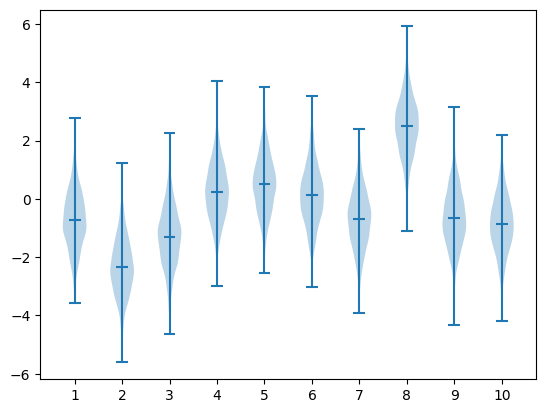

In [58]:
plt.violinplot(rewards,showmeans=True);
plt.xticks(torch.linspace(1,k,k));
# each boxplot represents a the distribution of rewards given by a bandit. the distribution depends on the action value.
# where the action value represents the "true" rewards --> it is defined as the expected value of the rewards given an action a at time step t

# thus what we are doing it:
# - taking one bandit
# - giving to that one bandit a action value (the "true reward") --> extracted from a normal distribution with mean 0 and variance 1
# - pulling the lever of the bandit 2000 times, recording each time the reward,
# - the reward is given by extracting a value from the reward function, that has mean equal to the action value and variance 1

# NB the reward is not always the same, it has a certain volatility, otherwise, the problem would be way simpler. see page 26:
# If you knew the value of each action, then it would be trivial to solve the k-armed bandit problem: you would always select the action with highest value.

## let's model the agent (stationary)

In [59]:
class MetaAgent():
    def __init__(self, k, best_action=None, ε=0.01):
        self.ε = ε
        self.k = k
        self.Q_estimate = torch.zeros(k)  # action value estimates
        self.N_count = torch.zeros(k)     # action counts
        self.rewards = []
        self.actions = []
        self.best_action = best_action

    def choose_action(self):
        if torch.rand(()) <= self.ε:
            action = torch.randint(self.k, (1,)).item()  # explore
        else:
            action = torch.argmax(self.Q_estimate).item()  # exploit

        self.actions.append(action)
        return action

    def update(self, reward, action):
        raise NotImplementedError


In [60]:
class EpsilonGreedyAgent(MetaAgent):
    def update(self, reward, action):
        # increment counter for the action
        self.N_count[action] += 1
        # update the estimate using incremental formula
        self.Q_estimate[action] += (reward - self.Q_estimate[action]) / self.N_count[action]
        self.rewards.append(reward)


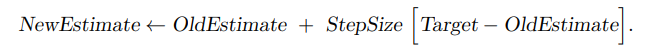

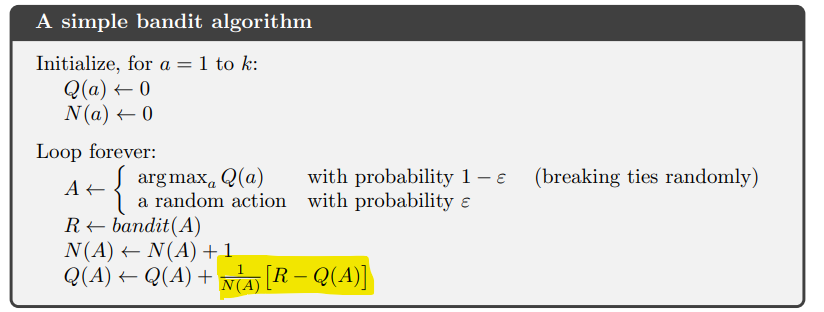

### simpler simulation

In [61]:
@dataclass
class AgentSim:
    agents: List[MetaAgent]
    mean_reward_per_step: torch.Tensor
    mean_optimal_action_per_step: torch.Tensor
    ε: float

In [62]:
def simulate(num_agents: int, steps: int, k: int, AgentType, **kwargs) -> AgentSim:
    all_rewards = torch.zeros(num_agents, steps)
    all_optimal_actions = torch.zeros(num_agents, steps)
    agents = []

    for i in range(num_agents):
        # Each agent gets its own bandit problem
        bandit = KArmedBandit(k)
        agent = AgentType(k, best_action=bandit.best_action, **kwargs)

        for t in range(steps):
            action = agent.choose_action()
            reward = bandit.pull(action)
            agent.update(reward, action)

            all_rewards[i, t] = reward
            all_optimal_actions[i, t] = 1.0 if action == bandit.best_action else 0.0

        agents.append(agent)

    mean_reward_per_step = all_rewards.mean(dim=0)
    mean_optimal_action_per_step = all_optimal_actions.mean(dim=0)
    ε = kwargs.get("ε", 0.0)

    return AgentSim(
        agents=agents,
        mean_reward_per_step=mean_reward_per_step,
        mean_optimal_action_per_step=mean_optimal_action_per_step,
        ε=ε
    )

In [15]:
agent_sim = simulate(num_agents = 10,steps =  1000, k = 10, AgentType=EpsilonGreedyAgent, ε = 0.1)

In [16]:
len(agent_sim.agents)

10

### simpler visualization

In [63]:
def viz(agent_sims, title="", colors=["red", "green", "blue"], labels=None):


    agent_sims = [agent_sims] if isinstance(agent_sims, AgentSim) else agent_sims
    if not labels:
        labels = [""]*len(agent_sims)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for sim, label, color in zip(agent_sims, labels, colors):
        ax[0].plot(sim.mean_reward_per_step, color=color, label=label)
        ax[1].plot(sim.mean_optimal_action_per_step * 100, color=color, label=label)

    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Average Reward")
    ax[0].set_title("Average Reward vs Steps")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("% Optimal Action")
    ax[1].set_title("% Optimal Action vs Steps")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



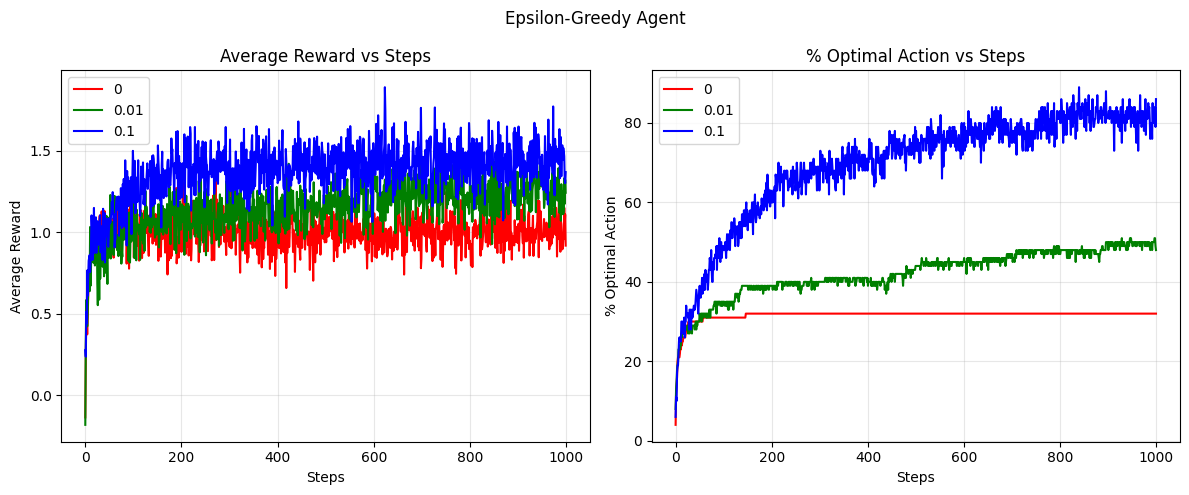

In [30]:
epsilons = [0.,0.01,0.1]
agent_sims = [simulate(num_agents = 100,steps= 1000,k = 10, AgentType= EpsilonGreedyAgent, ε =ε ) for ε in epsilons]
viz(agent_sims, "Epsilon-Greedy Agent", labels =epsilons)

## an agent with constant step size (non-stationary situations)

In [64]:
# constant step size α, good for nonstationary problems
# it gives more importance to the last few steps, rather than giving each step the same exact importance.
# usefull when the reward change in time

class EpsilonGreedyAgentConst(MetaAgent):
  def __init__(self, k,best_action=None, ε=0.01, α=0.1):
        super().__init__(k=k,best_action=best_action, ε = ε)
        self.α = α
  def update(self, reward, action):
        # increment counter for the action
        self.N_count[action] += 1
        step_size = self.α if self.α > 0 else 1.0 / self.N_count[action]

        # update the estimate using incremental formula
        self.Q_estimate[action] += step_size*(reward - self.Q_estimate[action])
        self.rewards.append(reward)

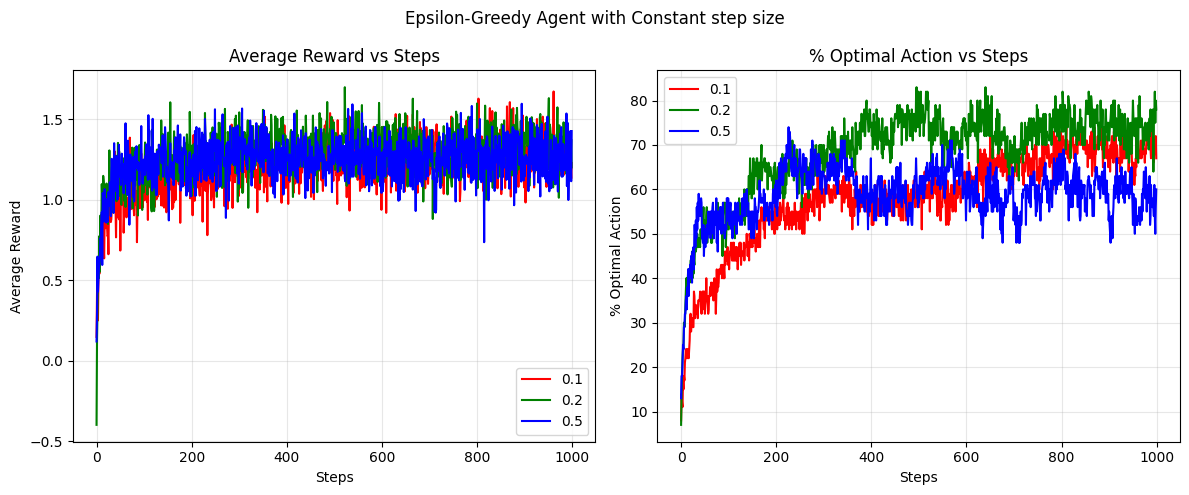

In [35]:
alphas = [0.1,0.2,0.5]
agent_sims = [simulate(num_agents=100, steps = 1000, k=10,AgentType= EpsilonGreedyAgentConst, α=α, ε=0.1) for α in alphas ]
viz(agent_sims, "Epsilon-Greedy Agent with Constant step size", labels = alphas)

## optimistic values

In [65]:
# At the start, all Q_estimate[a] are initialized higher than the true action values q∗(a).
class EpsilonGreedyAgentOpt(MetaAgent):

  def __init__(self, k,best_action=None, ε=0.01,α=0, optimistic_initial_value=0):
        super().__init__(k=k, best_action=best_action,ε = ε)
        self.α = α
        self.Q_estimate = torch.zeros(k) + optimistic_initial_value

  def update(self, reward, action):
        self.N_count[action] += 1
        step_size = self.α if self.α > 0 else 1.0 / self.N_count[action]
        self.Q_estimate[action] += step_size * (reward - self.Q_estimate[action])
        self.rewards.append(reward)

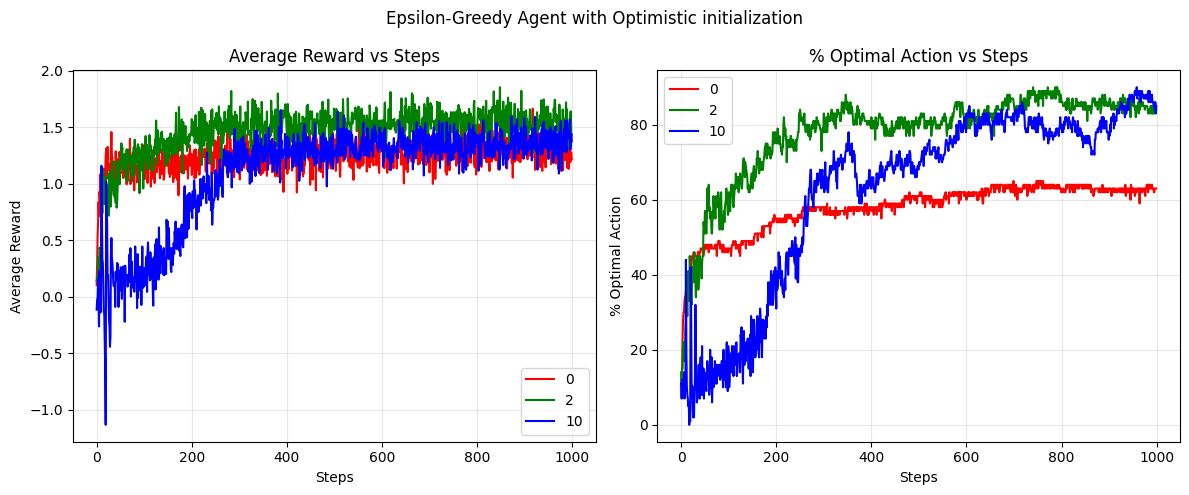

In [38]:
opts = [0,2,10]
agent_sims = [simulate(num_agents=100, steps = 1000, k=10,AgentType= EpsilonGreedyAgentOpt, α=0.1, ε=0,optimistic_initial_value = opt) for opt in opts ]
viz(agent_sims, "Epsilon-Greedy Agent with Optimistic initialization", labels = opts)

## comparison mix

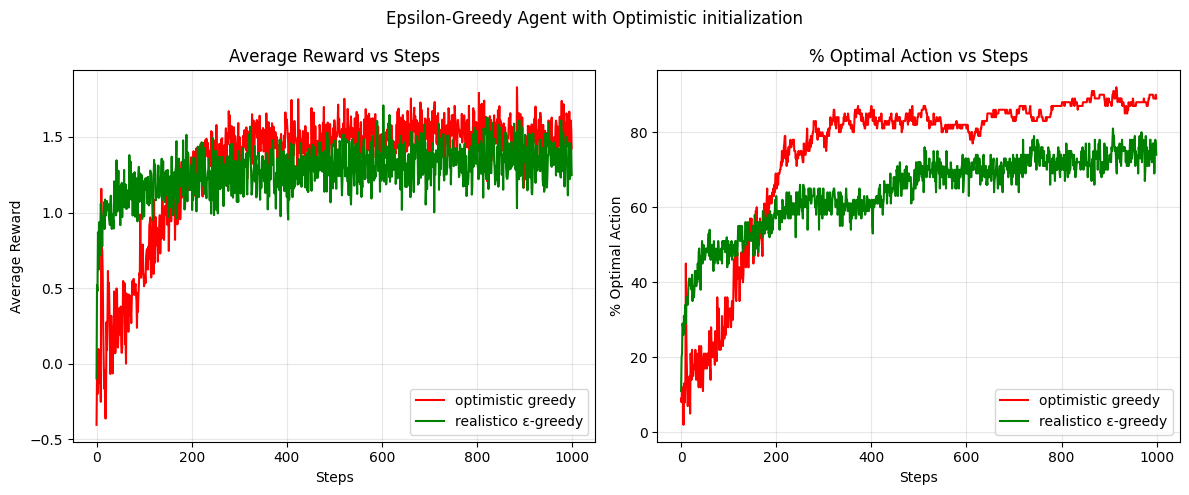

In [66]:
agent_sims = [simulate(num_agents=100, steps = 1000, k=10,AgentType= EpsilonGreedyAgentOpt, α=0.1, ε=0,optimistic_initial_value = 5),
              simulate(num_agents=100, steps = 1000, k=10,AgentType= EpsilonGreedyAgentOpt, α=0.1, ε=0.1,optimistic_initial_value = 0)]
viz(agent_sims, "Epsilon-Greedy Agent with Optimistic initialization", labels = ["optimistic greedy", "realistico ε-greedy"])